#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles

from tqdm import tqdm

In [2]:
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

#### Create datasets

In [4]:
nTot = 1000
circles_data, circles_labels = make_circles(n_samples = nTot)

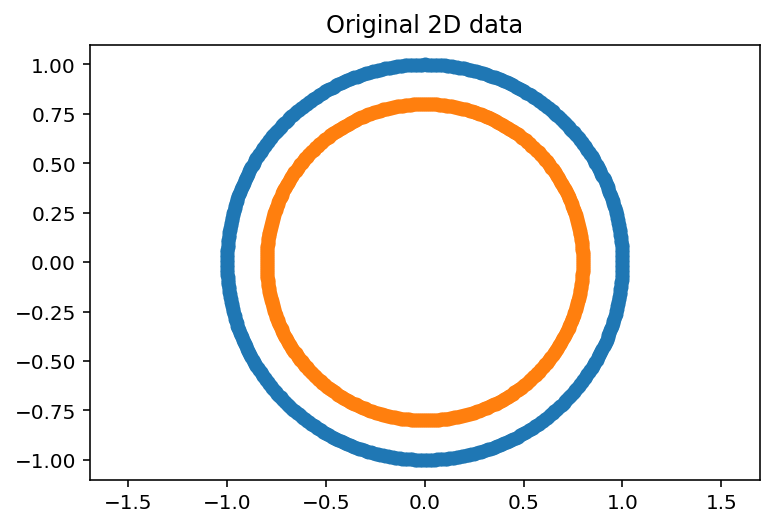

In [5]:
idx_0 = np.where(circles_labels==0)
idx_1 = np.where(circles_labels==1)
plt.scatter(circles_data[idx_0,0],circles_data[idx_0,1])
plt.scatter(circles_data[idx_1,0],circles_data[idx_1,1])
plt.axis('equal')
plt.title('Original 2D data')
plt.show()

#### Split datat into train and test

In [6]:
fracTrain = 0.8
fracTest = 1 - fracTrain

nTrain = int(nTot*fracTrain)
nTest = nTot - nTrain

In [7]:
nRounds = 3

In [8]:
repsTrain_solo = circles_data[:nTrain]
repsTest_solo = circles_data[nTrain:]

labelsTrain = circles_labels[:nTrain].astype(float)
labelsTest = circles_labels[nTrain:].astype(float)

In [9]:
dimProj = 10
A = np.random.rand(2,dimProj)

repsTrain_proj = repsTrain_solo@A
repsTest_proj = repsTest_solo@A

#### Make sequences

In [10]:
# def makeSequences(dataset,Trounds=1):
#     if Trounds==1:
#         return np.expand_dims(dataset,1)
#     elif Trounds>1:
#         numSamps, numFeats = dataset.shape
#         dataset_sequential = np.zeros((numSamps,Trounds,numFeats))
#         for kk in range(Trounds):
#             dataset_sequential[:,kk,:] = dataset
#         return dataset_sequential

In [11]:
# repsTrain = makeSequences(repsTrain_solo,nRounds)
# repsTest = makeSequences(repsTest_solo,nRounds)

#### Convert data to tensors

In [12]:
dataTrain = Variable(torch.from_numpy(repsTrain_proj)).requires_grad_(True)
yTrain = Variable(torch.from_numpy(labelsTrain)).requires_grad_(True)

dataTest = Variable(torch.from_numpy(repsTest_proj)).requires_grad_(True)
yTest = Variable(torch.from_numpy(labelsTest)).requires_grad_(True)

#### Train and test loaders

In [13]:
## create dataset and dataloader
tensorTrainData = TensorDataset(dataTrain,yTrain)
tensorTestData = TensorDataset(dataTest,yTest)

bs = 128 ## batch size
train_loader = DataLoader(tensorTrainData, batch_size=bs, shuffle=True)
train_loader_noShuffle = DataLoader(tensorTrainData, batch_size=bs, shuffle=False)
test_loader = DataLoader(tensorTestData, batch_size=bs, shuffle=False)

#### Test for CUDA

In [14]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU, training on CPU')
else:
    print('GPU found, training on GPU')

No GPU, training on CPU


#### MLP AE

In [15]:
n_latent = 2

In [16]:
class MLPAE(nn.Module):
    def __init__(self):
        super(MLPAE, self).__init__()
        
        ##Encoder
        self.layer1 = nn.Linear(10, 5)
        self.layer2 = nn.Linear(5,2)
        self.layer3 = nn.Linear(2, 5)
        self.layer4 = nn.Linear(5,10)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        
        ## layer 1
        x = F.relu(self.layer1(x))
        x = self.dropout(x)
        x = F.relu(self.layer2(x))
        x_latent = self.dropout(x)
        x = F.relu(self.layer3(x))
        x = self.dropout(x)
        x_recon = self.layer4(x)
        
        return x_recon, x_latent

#create the NN
model = MLPAE()
print(model)

#move tensors to GPU if available
if train_on_gpu:
    model.cuda()

MLPAE(
  (layer1): Linear(in_features=10, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=2, bias=True)
  (layer3): Linear(in_features=2, out_features=5, bias=True)
  (layer4): Linear(in_features=5, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


#### Count number of parameters

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

142

#### Trial pass

In [18]:
for data, target in train_loader:
    if train_on_gpu:
        data, target = data.float().cuda(), target.float().cuda()
        recon, latent = model(data)
    data, target = data.float(), target.float()
    recon, latent = model(data)
    

In [19]:
recon.shape

torch.Size([32, 10])

#### Train AE with MSE

#### Specify loss function and optimizer

In [20]:
#specify loss function
criterion = nn.MSELoss()

#optimizer
eta = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

data.dtype

torch.float32

#### Addresses to collect activations and models

In [21]:
# pp = 'Users\magicalkings\Final_project\tmp1\'
# npp = 'tmp2\'
# pp_npy = pp+npp+'npys/'
# pp_pts = pp+npp+'pts/'

#### Train the network

In [22]:
#number of epochs
n_epochs = 50
div = n_epochs//25 ## try ensuring that number used to divide by is a factor of n_epochs
train_losses = np.zeros(n_epochs)

train_loss_min = np.Inf
best_epoch = 0

for epoch in tqdm(range(1,n_epochs+1)):
    train_loss = 0.0
    cnt = 0
    
    #train model
    model.train()
    for data, target in train_loader:
        data, target = data.float(), target.float()
        if train_on_gpu:
            data, target = data.float().cuda(), target.float().cuda()
        
        optimizer.zero_grad() #clears older gradients
        output, _hidden = model(data) #forward pass
        loss = criterion(output,data) #calculate the loss for the batch
        loss.backward() #backprop
        optimizer.step() #update parameters in direction of the -ve gradient
        train_loss += loss.item()*data.size(0) #update training loss
        
    #calculate average loss
    train_loss = train_loss/len(train_loader.dataset)
    
    #training/validation stats
#     print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    train_losses[epoch-1] = train_loss
    
    #save model if the training loss decreased
    if train_loss <= train_loss_min:
        print('Epoch: {}, Train Loss Decreased!! ({:.6f}-->{:.6f})'.format(epoch,train_loss_min,train_loss))
        torch.save(model.state_dict(),'MLPAE.pt')
        train_loss_min = train_loss
        best_epoch = epoch
        
    if epoch%div == 0:
        torch.save(model.state_dict(), 'MLPAE_epoch_'+str(epoch)+'.pt')
        
        activations_hidden_np = np.zeros((nTest,n_latent))
        
        activations_out_np = np.zeros((nTest,dimProj))
        
        # track test loss
        test_loss = 0.0
        
        model.eval()
        for data_test, target_test in test_loader:
            if train_on_gpu:
                data_test, target_test = data_test.float().cuda(), target_test.float().cuda()
            data_test, target_test = data_test.float(), target_test.float()
            ## outputs
            output_test, act_hidden = model(data_test)
            
            # calculate the batch loss
            loss = criterion(output_test,data_test)
            
            # update test loss 
            test_loss += loss.item()*data_test.size(0)
            
            act_hidden = np.squeeze(act_hidden.detach().cpu().numpy())
            output_test = np.squeeze(output_test.detach().cpu().numpy())
            
            for i in range(bs):
                if i < len(data_test):
                    label = target_test.data[i]

                    activations_hidden_np[cnt] = act_hidden[i]

                    activations_out_np[cnt] = output_test[i,-1]

                    cnt += 1

        np.save('MLPAE_latent_epoch_'+str(epoch), activations_hidden_np)
        
        np.save('MLPAE_out_epoch_'+str(epoch), activations_out_np)
        
        # average test loss
        test_loss = test_loss/len(test_loader.dataset)
        print('Test Loss: {:.6f}\n'.format(test_loss))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, Train Loss Decreased!! (inf-->0.473455)


 12%|█▏        | 6/50 [00:00<00:02, 16.50it/s]

Epoch: 2, Train Loss Decreased!! (0.473455-->0.450820)
Test Loss: 0.417111

Epoch: 3, Train Loss Decreased!! (0.450820-->0.441127)
Epoch: 4, Train Loss Decreased!! (0.441127-->0.418038)
Test Loss: 0.389605

Epoch: 5, Train Loss Decreased!! (0.418038-->0.411232)
Epoch: 6, Train Loss Decreased!! (0.411232-->0.396605)
Test Loss: 0.365867

Epoch: 7, Train Loss Decreased!! (0.396605-->0.379885)
Epoch: 8, Train Loss Decreased!! (0.379885-->0.373440)
Test Loss: 0.344504



 24%|██▍       | 12/50 [00:00<00:01, 21.23it/s]

Epoch: 9, Train Loss Decreased!! (0.373440-->0.361265)
Epoch: 10, Train Loss Decreased!! (0.361265-->0.351262)
Test Loss: 0.325806

Epoch: 11, Train Loss Decreased!! (0.351262-->0.341712)
Epoch: 12, Train Loss Decreased!! (0.341712-->0.332312)
Test Loss: 0.308013

Epoch: 13, Train Loss Decreased!! (0.332312-->0.324567)
Epoch: 14, Train Loss Decreased!! (0.324567-->0.314166)
Test Loss: 0.291037



 30%|███       | 15/50 [00:00<00:01, 22.09it/s]

Epoch: 15, Train Loss Decreased!! (0.314166-->0.311451)
Epoch: 16, Train Loss Decreased!! (0.311451-->0.307244)
Test Loss: 0.276138

Epoch: 17, Train Loss Decreased!! (0.307244-->0.294742)


 36%|███▌      | 18/50 [00:00<00:01, 21.81it/s]

Epoch: 18, Train Loss Decreased!! (0.294742-->0.288098)
Test Loss: 0.262491

Epoch: 19, Train Loss Decreased!! (0.288098-->0.284009)


 42%|████▏     | 21/50 [00:00<00:01, 21.21it/s]

Epoch: 20, Train Loss Decreased!! (0.284009-->0.278447)
Test Loss: 0.250022

Epoch: 21, Train Loss Decreased!! (0.278447-->0.271438)
Epoch: 22, Train Loss Decreased!! (0.271438-->0.268209)
Test Loss: 0.238116



 48%|████▊     | 24/50 [00:00<00:01, 22.91it/s]

Epoch: 23, Train Loss Decreased!! (0.268209-->0.260027)
Epoch: 24, Train Loss Decreased!! (0.260027-->0.259141)
Test Loss: 0.226601

Epoch: 25, Train Loss Decreased!! (0.259141-->0.254625)


 54%|█████▍    | 27/50 [00:01<00:00, 24.52it/s]

Epoch: 26, Train Loss Decreased!! (0.254625-->0.245844)
Test Loss: 0.215862

Epoch: 27, Train Loss Decreased!! (0.245844-->0.244204)
Epoch: 28, Train Loss Decreased!! (0.244204-->0.237696)
Test Loss: 0.205366



 60%|██████    | 30/50 [00:01<00:00, 25.07it/s]

Epoch: 29, Train Loss Decreased!! (0.237696-->0.231675)
Epoch: 30, Train Loss Decreased!! (0.231675-->0.230265)
Test Loss: 0.195054

Epoch: 31, Train Loss Decreased!! (0.230265-->0.226004)


 68%|██████▊   | 34/50 [00:01<00:00, 26.43it/s]

Epoch: 32, Train Loss Decreased!! (0.226004-->0.224817)
Test Loss: 0.185465

Epoch: 33, Train Loss Decreased!! (0.224817-->0.215871)
Epoch: 34, Train Loss Decreased!! (0.215871-->0.210386)
Test Loss: 0.176164

Epoch: 35, Train Loss Decreased!! (0.210386-->0.209608)
Epoch: 36, Train Loss Decreased!! (0.209608-->0.205685)
Test Loss: 0.167290

Epoch: 37, Train Loss Decreased!! (0.205685-->0.203563)
Epoch: 38, Train Loss Decreased!! (0.203563-->0.198273)


 84%|████████▍ | 42/50 [00:01<00:00, 28.48it/s]

Test Loss: 0.158822

Epoch: 40, Train Loss Decreased!! (0.198273-->0.197511)
Test Loss: 0.150937

Epoch: 41, Train Loss Decreased!! (0.197511-->0.190888)
Test Loss: 0.143763

Epoch: 43, Train Loss Decreased!! (0.190888-->0.186054)
Epoch: 44, Train Loss Decreased!! (0.186054-->0.183206)
Test Loss: 0.137282



 98%|█████████▊| 49/50 [00:01<00:00, 29.40it/s]

Epoch: 45, Train Loss Decreased!! (0.183206-->0.172752)
Test Loss: 0.131047

Test Loss: 0.125357



100%|██████████| 50/50 [00:01<00:00, 26.67it/s]

Test Loss: 0.120084



Text(0, 0.5, 'MSE')

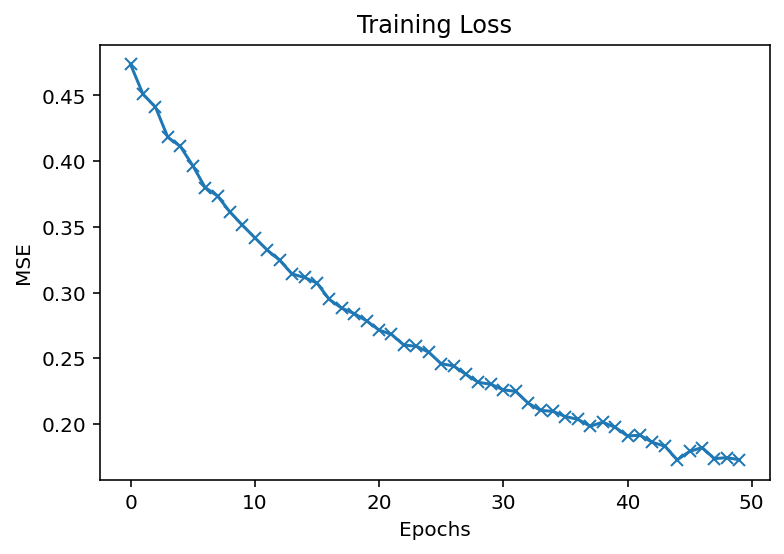

In [23]:
plt.plot((train_losses),'-x')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')

#### Load best model

In [24]:
## best epoch = 50
print(best_epoch)

45


In [25]:
model.load_state_dict(torch.load('MLPAE.pt'))

<All keys matched successfully>

In [26]:
model.eval()

test_loss = 0.0
        
activations_latent_np = np.zeros((nTest,n_latent))
activations_out_np = np.zeros((nTest,dimProj))

cnt = 0

for data_test, target_test in test_loader:
    if train_on_gpu:
        data_test, target_test = data_test.float().cuda(), target_test.float().cuda()
    data_test, target_test = data_test.float(), target_test.float()
    ## outputs
    output_test, act_hidden = model(data_test)

    # calculate the batch loss
    loss = criterion(output_test, data_test)

    # update test loss 
    test_loss += loss.item()*data_test.size(0)

    act_hidden = np.squeeze(act_hidden.detach().cpu().numpy())
    output_test = np.squeeze(output_test.detach().cpu().numpy())

    for i in range(bs):
        if i < len(data_test):
            label = target_test.data[i]

            activations_hidden_np[cnt] = act_hidden[i]

            activations_out_np[cnt] = output_test[i,-1]

            cnt += 1

np.save('MLPAE_latent_epoch_'+str(best_epoch), activations_hidden_np)
np.save('MLPAE_out_epoch_'+str(best_epoch), activations_out_np)

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 0.134254



In [27]:
model.eval()

train_loss = 0.0
        
activations_latent_train_np = np.zeros((nTrain,n_latent))
activations_out_train_np = np.zeros((nTrain,dimProj))

cnt = 0

for data_train, target_train in train_loader_noShuffle:
    if train_on_gpu:
        data_train, target_train = data_train.float().cuda(), target_train.float().cuda()
    data_train, target_train = data_train.float(), target_train.float()

    ## outputs
    output_train, act_hidden = model(data_train)

    # calculate the batch loss
    loss = criterion(output_train, data_train)

    # update train loss 
    train_loss += loss.item()*data_train.size(0)

    act_hidden = np.squeeze(act_hidden.detach().cpu().numpy())
    output_train = np.squeeze(output_train.detach().cpu().numpy())

    for i in range(bs):
        if i < len(data_train):
            label = target_train.data[i]

            activations_latent_train_np[cnt] = act_hidden[i]

            activations_out_train_np[cnt] = output_train[i,-1]

            cnt += 1

# np.save('MLPAE_latent_epoch_'+str(best_epoch), activations_hidden_np)
# np.save('MLPAE_out_epoch_'+str(best_epoch), activations_out_np)

# average train loss
train_loss = train_loss/len(train_loader.dataset)
print('Test Loss: {:.6f}\n'.format(train_loss))

Test Loss: 0.133975



#### Plot latent data

Text(0.5, 1.0, 'Latent Space - Test Data')

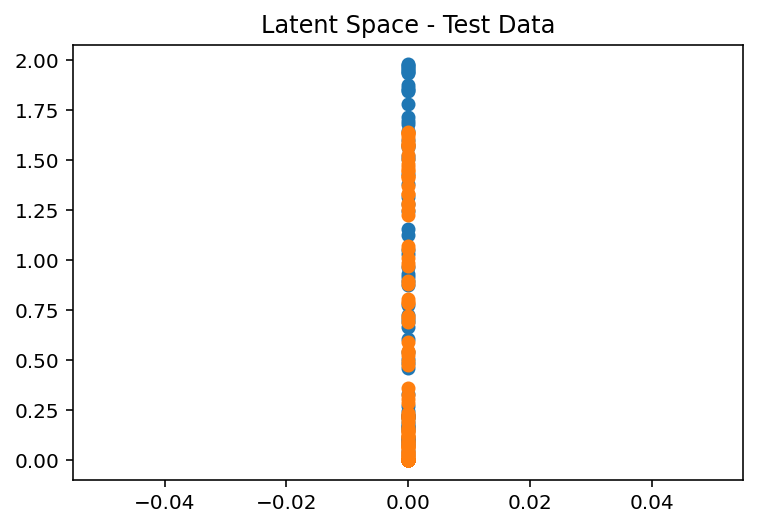

In [28]:
for ii in range(2):
    col = 'C' + str(ii)
    idx = np.where(labelsTest==ii)[0]
    plt.scatter(activations_hidden_np[idx,0],activations_hidden_np[idx,1],c=col)
plt.title('Latent Space - Test Data')

In [29]:
# for ii in range(2):
#     col = 'C' + str(ii)
#     idx = np.where(labelsTrain==ii)[0]
#     plt.scatter(activations_latent_train_np[idx,0],activations_latent_train_np[idx,1],c=col)
# plt.title('Train data')

#### Train a linear classifier on top of latent representations

In [45]:
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn import svm

In [31]:
# clf = Perceptron(tol=1e-3, random_state=22)
# clf.fit(activations_latent_train_np, labelsTrain)
# print('Train Accuracy = ',clf.score(activations_latent_train_np, labelsTrain))
# print('Test Accuracy = ',clf.score(activations_hidden_np, labelsTest))

In [38]:
# clf = MLPClassifier(random_state=22,max_iter=1000, hidden_layer_sizes=(20,3))
# clf.fit(activations_latent_train_np, labelsTrain)
# print('Train Accuracy = ',clf.score(activations_latent_train_np, labelsTrain))
# print('Test Accuracy = ',clf.score(activations_hidden_np, labelsTest))

Train Accuracy =  0.63375
Test Accuracy =  0.605


In [48]:
clf = svm.SVC()
clf.fit(activations_latent_train_np, labelsTrain)
print('Train Accuracy = ',clf.score(activations_latent_train_np, labelsTrain))
print('Test Accuracy = ',clf.score(activations_hidden_np, labelsTest))

Train Accuracy =  0.6175
Test Accuracy =  0.56


In [46]:
nRuns = 5
numTrainSamps = [10,25,50,100,200,300,400,500,600,700,800]
acc_list_train = np.zeros((nRuns,len(numTrainSamps)))
acc_list_test = np.zeros((nRuns,len(numTrainSamps)))

for ii in range(nRuns):
    for cnt, kk in enumerate(numTrainSamps):
            idxs = np.sort(np.random.choice(nTrain,kk,replace=False))
            clf_temp = MLPClassifier(random_state=22, max_iter=1000, hidden_layer_sizes=(20,3))
            clf_temp.fit(activations_latent_train_np[idxs], labelsTrain[idxs])
            acc_list_train[ii,cnt] = clf_temp.score(activations_latent_train_np[idxs], labelsTrain[idxs])
            acc_list_test[ii,cnt] = clf_temp.score(activations_hidden_np, labelsTest)

/Users/magicalkings/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/magicalkings/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/magicalkings/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/magicalkings/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

In [49]:
nRuns = 5
numTrainSamps = [10,25,50,100,200,300,400,500,600,700,800]
acc_list_train = np.zeros((nRuns,len(numTrainSamps)))
acc_list_test = np.zeros((nRuns,len(numTrainSamps)))

for ii in range(nRuns):
    for cnt, kk in enumerate(numTrainSamps):
            idxs = np.sort(np.random.choice(nTrain,kk,replace=False))
            clf_temp = svm.SVC()
            clf_temp.fit(activations_latent_train_np[idxs], labelsTrain[idxs])
            acc_list_train[ii,cnt] = clf_temp.score(activations_latent_train_np[idxs], labelsTrain[idxs])
            acc_list_test[ii,cnt] = clf_temp.score(activations_hidden_np, labelsTest)

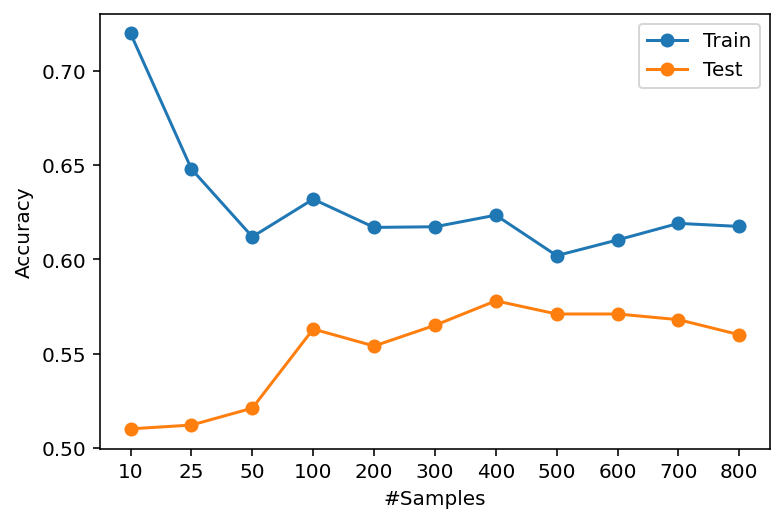

In [50]:
plt.plot(np.mean(acc_list_train,axis=0),'-o',label='Train')
plt.plot(np.mean(acc_list_test,axis=0),'-o',label='Test')
plt.legend()
plt.xticks(np.arange(len(numTrainSamps)),np.array(numTrainSamps))
plt.ylabel('Accuracy')
plt.xlabel('#Samples')
plt.show()